In [1]:
from diffusers import UNet3DConditionModel
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
depth,height, width=45,16,9
batch_size=10
sequence_length=45
# Initialize the model
model = UNet3DConditionModel(
    sample_size=(depth, height, width),
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128, 128),
    down_block_types=(
        "DownBlock3D", "DownBlock3D", "CrossAttnDownBlock3D", "CrossAttnDownBlock3D"
    ),
    up_block_types=(
        "CrossAttnUpBlock3D", "CrossAttnUpBlock3D", "UpBlock3D", "UpBlock3D"
    ),
    norm_num_groups=16,
    cross_attention_dim=64
)

# Prepare inputs
# sample = torch.randn(batch_size, 1, depth, height, width)  # Noisy input
# timestep = torch.tensor([10])  # Current timestep

# ### my concern right now.......
# encoder_hidden_states = torch.randn(batch_size, sequence_length, 128)  # Conditioning input

# Forward pass


/home/fa7sa/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 21,723,937


In [35]:
output.sample.device

device(type='cpu')

In [22]:
batch = torch.load('/project/biocomplexity/fa7sa/Diffusion_multi_step/autoregressive-diffusion-pytorch/sample_batch.pt')
x = batch['input'][:16]
cond = batch['condition'][:16]
print("Loaded shapes:", x.shape, cond.shape)

Loaded shapes: torch.Size([16, 1, 45, 16, 9]) torch.Size([16, 46])


In [27]:
import torch
import torch.nn as nn
import math

def get_2d_cylindrical_pos_embed(A=16, R=9, dim=32, temperature=10000):
    """
    Fixed 2D cylindrical positional embedding.
    Each voxel gets a unique position vector based on angle and radius.
    """
    y, x = torch.meshgrid(
        torch.arange(A) / A, torch.arange(R) / R, indexing='ij'
    )
    fourier_dim = dim // 4
    omega = 1. / (temperature ** (torch.arange(fourier_dim) / (fourier_dim - 1)))
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.reshape(A, R, dim)

class LayerwiseTransformerConditioner(nn.Module):
    def __init__(
        self,
        voxel_dim=(16, 9),
        cond_scalar_dim=2,  # incident energy + layer total energy
        pos_dim=32,
        model_dim=128,
        depth=4,
        heads=4,
        decoder_class=None,  # pass your causal Decoder class here
        **decoder_kwargs
    ):
        super().__init__()
        self.A, self.R = voxel_dim
        self.pos_dim = pos_dim
        self.model_dim = model_dim

        # Fixed cylindrical positional embedding (non-trainable)
        pos = get_2d_cylindrical_pos_embed(self.A, self.R, dim=self.pos_dim)
        self.register_buffer("pos_embed", pos, persistent=False)  # (A, R, pos_dim)

        # Linear projection for each voxel+pos pair + scalar info
        self.voxel_proj = nn.Linear(1 + self.pos_dim, model_dim)

        # Scalar info (incident energy + total layer energy) projection
        self.scalar_proj = nn.Linear(cond_scalar_dim, model_dim)

        # Causal transformer to process full (B, 45, model_dim) sequences
        assert decoder_class is not None, "Please pass your Decoder (causal transformer) class"
        self.transformer = decoder_class(
            dim=model_dim,
            depth=depth,
            heads=heads,
            attn_dim_head=model_dim // heads,
    #     #     decoder_kwargs={
    #     # 'rotary_pos_emb': False  # disable RoPE
    # }
            **decoder_kwargs
        )

    def forward(self, x, energy_vec):
        """
        x: (B, 1, 45, 16, 9) - voxel energy
        energy_vec: (B, 46), where energy_vec[:, 0] = incident_energy, energy_vec[:, 1:] = total per layer
        Returns: (B, 45, model_dim) - one vector per layer
        """
        B, _, D, A, R = x.shape
        assert D == 45 and energy_vec.shape == (B, 46)

        incident = energy_vec[:, 0].unsqueeze(-1)  # (B, 1)
        layer_totals = energy_vec[:, 1:]           # (B, 45)

        # Prepare previous layer voxel energy
        prev_voxel = torch.zeros(B, D, A, R, device=x.device)
        prev_voxel[:, 1:] = x[:, 0, :-1]  # Layer i gets i-1's voxel
        print("prev_voxel shape: ",prev_voxel.shape)
        prev_voxel = prev_voxel.unsqueeze(-1)  # (B, 45, 16, 9, 1)
        print("prev_voxel shape again: ",prev_voxel.shape)

        # Add positional encoding
        pos = self.pos_embed.to(x.device)  # (16, 9, pos_dim)
        pos = pos.unsqueeze(0).unsqueeze(0).expand(B, D, -1, -1, -1)  # (B, 45, 16, 9, pos_dim)

        voxel_plus_pos = torch.cat([prev_voxel, pos], dim=-1)  # (B, 45, 16, 9, 1 + pos_dim)
        voxel_proj = self.voxel_proj(voxel_plus_pos)  # (B, 45, 16, 9, model_dim)

        # Mean-pool over (A, R)
        voxel_repr = voxel_proj.mean(dim=(2, 3))  # (B, 45, model_dim)

        # Prepare scalar features: incident energy and layer total
        scalar_feats = torch.cat([
            incident.unsqueeze(1).expand(-1, D, -1),      # (B, 45, 1)
            layer_totals.unsqueeze(-1)                   # (B, 45, 1)
        ], dim=2)  # (B, 45, 2)

        scalar_proj = self.scalar_proj(scalar_feats)  # (B, 45, model_dim)

        # Combine voxel + scalar info
        combined = voxel_repr + scalar_proj  # (B, 45, model_dim)

        return self.transformer(combined)  # (B, 45, model_dim)


In [28]:

from x_transformers import Decoder

conditioner = LayerwiseTransformerConditioner(
    voxel_dim=(16, 9),
    model_dim=64,
    decoder_class=Decoder,  # <- your causal transformer class
    
).to(x.device)

2025-04-16 15:09:29.604 | WARNING  | x_transformers.x_transformers:__init__:2004 - when training language model, rotary embedding dimension should be at least 32


In [29]:
cond.device

device(type='cuda', index=0)

In [30]:
cond_vector = conditioner(x, cond) 

prev_voxel shape:  torch.Size([16, 45, 16, 9])
prev_voxel shape again:  torch.Size([16, 45, 16, 9, 1])


In [26]:
cond_vector.shape

torch.Size([16, 45, 64])

In [7]:
model.to(x.device)

UNet3DConditionModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (transformer_in): TransformerTemporalModel(
    (norm): GroupNorm(16, 32, eps=1e-06, affine=True)
    (proj_in): Linear(in_features=32, out_features=512, bias=True)
    (transformer_blocks): ModuleList(
      (0): BasicTransformerBlock(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn1): Attention(
          (to_q): Linear(in_features=512, out_features=512, bias=False)
          (to_k): Linear(in_features=512, out_features=512, bias=False)
          (to_v): Linear(in_features=512, out_features=512, bias=False)
          (to_out): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Dr

In [8]:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler(num_train_timesteps=100)

In [23]:
def train_step(x_real, cond_vector, model, scheduler):
    """
    x_real: (B, 1, 45, 16, 9) - real clean voxel data
    cond_vector: (B, 45, 128) - transformer-generated condition vectors
    """
    #print("inside the train step")
    noise = torch.randn_like(x_real)
    timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (x_real.shape[0],), device=x_real.device).long()

    # Add noise to the clean input
    x_noisy = scheduler.add_noise(x_real, noise, timesteps)

    # Predict the noise using your conditional UNet
    noise_pred = model(
        sample=x_noisy,
        timestep=timesteps,
        encoder_hidden_states=cond_vector
    ).sample

    # Loss: L2 between predicted noise and actual noise
    loss = torch.nn.functional.mse_loss(noise_pred, noise)
    return loss

In [15]:
import matplotlib.pyplot as plt

def plot_losses(avg_loss, title="Training Loss", save_path="loss_plot.png"):
    """
    Plots training loss curve.

    Parameters:
    - avg_loss (list of float): List of loss values (e.g., per epoch or step)
    - title (str): Title of the plot
    - save_path (str): File path to save the plot
    """
    plt.figure(figsize=(8, 5))
    plt.plot(avg_loss, label="Loss", color='blue', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


In [24]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
avg_loss=[]
for e in range(50):
    cond_vector = conditioner(x, cond)  # compute new graph every epoch
    
    loss = train_step(x, cond_vector, model, scheduler)
    avg_loss.append(loss)
    #print(f"Epoch {e} loss is {loss.item():.4f}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


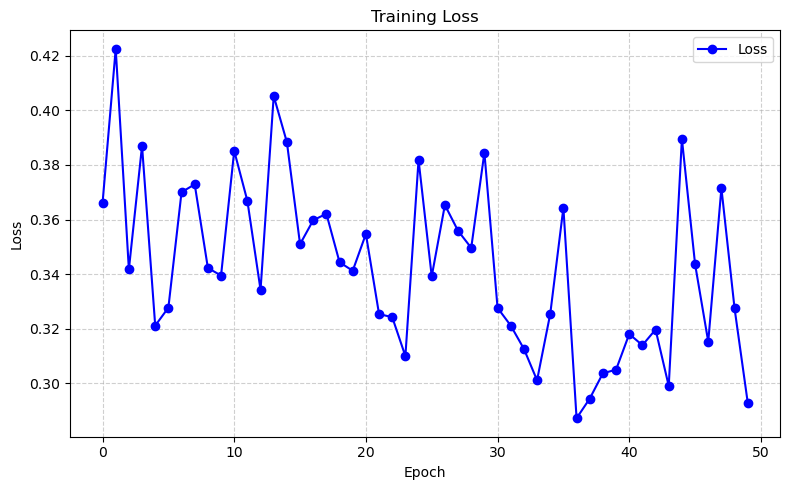

In [25]:
plot_losses(torch.tensor(avg_loss).cpu())

In [20]:
avg_loss

AttributeError: 'list' object has no attribute 'device'